In [1]:
import sys 
sys.path.append('..')

In [2]:
from treecrf import TreeCRFSimulation

In [3]:
import torch
import seaborn as sns
import pandas as pd
import numpy as np
from pandas import DataFrame
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import Adam

In [4]:
%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

In [5]:
%load_ext autoreload
%autoreload 2

In [12]:
def compare_k(treecrf, K1, K2, proposal='localglobal', N=100, yloc=0.2, offset=0.1, xlim=None):
    with torch.no_grad():
        log_z_exact = treecrf.log_partition()
        log_z_exact = log_z_exact[0].cpu().item()

        log_z_est_0 = []
        log_z_est_1 = []
        log_z_est_2 = []
        log_z_est_3 = []
        log_z_est_4 = []
        for _ in tqdm(range(N)):
            est = treecrf.log_partition_approx(K1=K1[0], K2=K2[0], proposal=proposal)
            log_z_est_0.append(est[0].cpu().item())

            est = treecrf.log_partition_approx(K1=K1[1], K2=K2[1], proposal=proposal)
            log_z_est_1.append(est[0].cpu().item())

            est = treecrf.log_partition_approx(K1=K1[2], K2=K2[2], proposal=proposal)
            log_z_est_2.append(est[0].cpu().item())
            
            est = treecrf.log_partition_approx(K1=K1[3], K2=K2[3], proposal=proposal)
            log_z_est_3.append(est[0].cpu().item())
            
            est = treecrf.log_partition_approx(K1=K1[4], K2=K2[4], proposal=proposal)
            log_z_est_4.append(est[0].cpu().item())

        estimates = pd.DataFrame(
            {
             'estimates': np.array(
                 log_z_est_0 + log_z_est_1 + log_z_est_2 + log_z_est_3 + log_z_est_4
             ), 
             'proposal': np.array(
                                  ['K1=%d K2=%d' % (K1[0], K2[0])] * N
                                  + ['K1=%d K2=%d' % (K1[1], K2[1])] * N
                                  + ['K1=%d K2=%d' % (K1[2], K2[2])] * N
                                  + ['K1=%d K2=%d' % (K1[3], K2[3])] * N
                                  + ['K1=%d K2=%d' % (K1[4], K2[4])] * N
                                 )}
            )

        plt.figure(figsize=(4,2))
        ax = sns.kdeplot(data=estimates, x="estimates", hue='proposal', fill=True, alpha=.2)
        ax.set(ylabel=None)
        plt.axvline(x=log_z_exact, color='#CC2F27')
        plt.tick_params(axis='both', which='both', left=False, bottom=True, right=False, top=False, labelleft=False, labelbottom=True) 
        plt.xlim(xlim)
        # move_legend(ax, 'upper left')
        
        print('bias:')
        print(np.mean(log_z_est_0) - log_z_exact, 
              np.mean(log_z_est_1) - log_z_exact, 
              np.mean(log_z_est_2) - log_z_exact,
              np.mean(log_z_est_3) - log_z_exact,
              np.mean(log_z_est_4) - log_z_exact
             )
        print('variance:')
        print(np.var(log_z_est_0), np.var(log_z_est_1), np.var(log_z_est_2), np.var(log_z_est_3), np.var(log_z_est_4))
        print('mse')
        print(
              np.mean((np.array(log_z_est_0) - log_z_exact)**2), 
              np.mean((np.array(log_z_est_1) - log_z_exact)**2), 
              np.mean((np.array(log_z_est_2) - log_z_exact)**2),
              np.mean((np.array(log_z_est_3) - log_z_exact)**2),
              np.mean((np.array(log_z_est_4) - log_z_exact)**2)
             )
    return 

# Dense

In [9]:
batch_size = 1
max_len = 15
num_states = 2000
hidden_size = 100
treecrf_d = TreeCRFSimulation(batch_size, max_len, num_states, hidden_size).to('cuda')
treecrf_d.entropy_approx()

tensor(6.4740, device='cuda:0', grad_fn=<MeanBackward0>)

100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


bias:
-0.028436889648446595 0.7739376831054869 1.09314331054685 0.8478552246093614 1.7595565795898551
variance:
0.01429355635084212 3.5531950467619113 3.537968183798343 1.8593495726116003 0.521796490761917
mse
0.01510221304371953 4.152174584092572 4.732930481191724 2.578208054509014 3.617835847539827


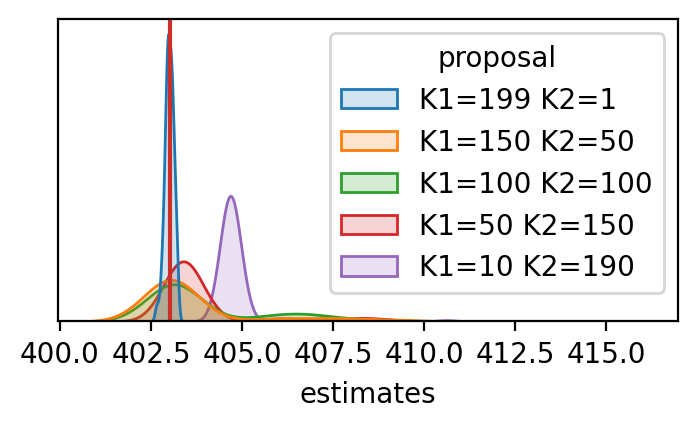

In [14]:
K1 = [199, 150, 100, 50, 10]
K2 = [1, 50, 100, 150, 190]
compare_k(treecrf_d, K1, K2, proposal='localglobal', N=100, yloc=0.2, offset=0.1, xlim=None)

# Intermediate

In [15]:
batch_size = 1
max_len = 15
num_states = 2000
hidden_size = 100
treecrf_i = TreeCRFSimulation(batch_size, max_len, num_states, hidden_size).to('cuda')
print(treecrf_i.entropy_approx())

optimizer = Adam(treecrf_i.parameters(), lr=1e-4)
for _ in tqdm(range(30)):
    treecrf_i.zero_grad()
    ent = treecrf_i.entropy_approx()
    ent.backward()
    optimizer.step()
print(ent)

100%|██████████| 30/30 [00:00<00:00, 155.75it/s]

tensor(6.6580, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4586, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


bias:
-0.0001644897461119399 0.7025988769531182 0.7953509521484534 1.1235546875000182 3.309958801269545
variance:
0.006990051565598696 2.186311767904461 2.431253608480468 3.446652012551576 1.5851356906044296
mse
0.006990078622475266 2.679956949800253 3.0638367455638944 4.7090271483547985 12.540962956706062


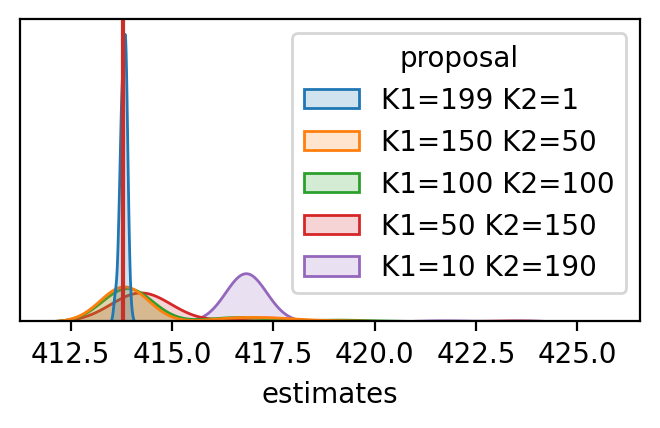

In [16]:
K1 = [199, 150, 100, 50, 10]
K2 = [1, 50, 100, 150, 190]
compare_k(treecrf_i, K1, K2, proposal='localglobal', N=100, yloc=0.2, offset=0.1, xlim=None)

# Long-tail

In [17]:
batch_size = 1
max_len = 15
num_states = 2000
hidden_size = 100
treecrf_l = TreeCRFSimulation(batch_size, max_len, num_states, hidden_size).to('cuda')
print(treecrf_l.entropy_approx())

optimizer = Adam(treecrf_l.parameters(), lr=1e-4)
for _ in tqdm(range(50)):
    treecrf_l.zero_grad()
    ent = treecrf_l.entropy_approx()
    ent.backward()
    optimizer.step()
print(ent)

100%|██████████| 50/50 [00:00<00:00, 701.21it/s]

tensor(6.5926, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2335, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


bias:
0.07946014404296875 0.7368450927734216 1.00317749023435 0.9401144409179665 3.0916854858398324
variance:
0.648579243614804 3.405497764792665 2.6945670335233207 1.9636043178300375 0.9706561669590883
mse
0.6548931581061334 3.9484384555369614 3.700932110436261 2.847419479852542 10.529175310311839


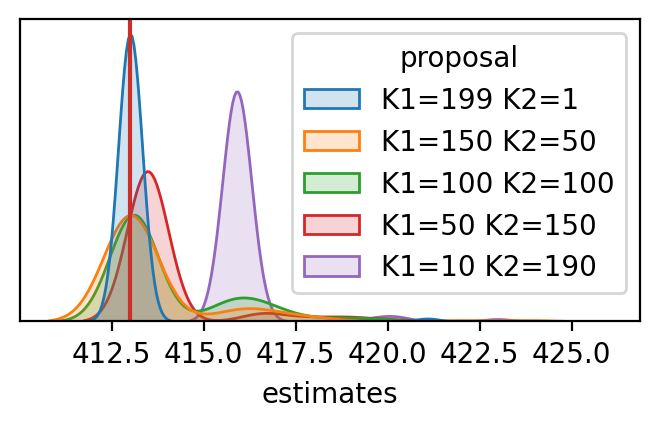

In [19]:
K1 = [199, 150, 100, 50, 10]
K2 = [1, 50, 100, 150, 190]
compare_k(treecrf_l, K1, K2, proposal='localglobal', N=100, yloc=0.2, offset=0.1, xlim=None)